In [1]:
import os
import sys
projectDir = '/mnt/c/Users/Julien Fournier/Documents/GitHub/RakutenTeam'
sys.path.append(projectDir)

import src.config as config
config.path_to_project = projectDir
config.path_to_data = os.path.join(projectDir, 'data', 'clean')
config.path_to_images = '/home/jul/DST/Rakuten/Data/images/image_train_resized'
config.path_to_models = '/mnt/c/Users/Julien Fournier/Documents/DST/RakutenProject/models'


import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV

import tensorflow as tf

from Rakuten_preprocessing import Rakuten_img_path

from src.text.classifiers import TFbertClassifier
from src.image.classifiers import ImgClassifier
from src.multimodal.classifiers import TFmultiClassifier
from src.utils.plot import classification_results, plot_training_history

from sklearn.metrics import f1_score

2024-03-07 14:52:55.652093: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-07 14:52:55.705833: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-07 14:52:55.705865: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-07 14:52:55.707361: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-07 14:52:55.718357: I tensorflow/core/platform/cpu_feature_guar

In [2]:
data_train = pd.read_csv(os.path.join(config.path_to_data, 'df_train_index.csv'))
data_train['testset'] = False
data_test = pd.read_csv(os.path.join(config.path_to_data, 'df_test_index.csv'))
data_test['testset'] = True
data = pd.concat([data_train, data_test], axis=0)

#merging text into token column
colnames = ['designation_translated', 'description_translated'] #['designation', 'description']#
data['tokens'] = data[colnames].apply(lambda row: ' '.join(s.lower() for s in row if isinstance(s, str)), axis=1)

#path to images into img_path column
data['img_path'] = Rakuten_img_path(img_folder=config.path_to_images,
                             imageid=data['imageid'], productid=data['productid'], suffix='_resized')


In [3]:
#labels of encoded classes
class_labels = data.groupby('prdtypedesignation')['prdtypeindex'].first().reset_index()
class_labels.index = class_labels['prdtypeindex']
class_labels = class_labels.drop(columns='prdtypeindex').sort_index()

## In case we want to clean up the text

In [5]:
#tokenize multiple columns
from nltk.tokenize import word_tokenize

data['tokens'] = data['tokens'].str.lower().apply(lambda x: word_tokenize(x, language='french'))

In [ ]:
def remove_wordsubset(words, wordsubset):
    #remove words in wordsubset
    words_filtered = [word for word in words if word not in wordsubset]
    return words_filtered

def remove_token_duplicates(words):
    #remove duplicated tokens, keeping the same order
    wordset = set()
    words_filtered = [wordset.add(word) or word for word in words if word not in wordset]
    return words_filtered

In [ ]:
#Removing stop words
from nltk.corpus import stopwords
stop_words = set(stopwords.words('french'))
data['tokens'] = data['tokens'].apply(lambda x: remove_wordsubset(x, stop_words))

In [ ]:
#Removing puntuation
punctuations = [",", ".", "``", "@", "*", "(", ")", "...", "!", "?", "-", "_", ">", "<", ":", "/", "=", "--", "©", "~", ";", "\\", "\\\\"]
data['tokens'] = data['tokens'].apply(lambda x: remove_wordsubset(x, punctuations))

In [ ]:
#Removing duplicated tokens
data['tokens'] = data['tokens'].apply(lambda x: remove_token_duplicates(x))

In [6]:
#Converting list of tokens to string
data['tokens'] = data['tokens'].apply(lambda x:  ' '.join(x))

## Creating train and test sets

In [4]:
Img_train = data.loc[~data['testset'], 'img_path']
Img_test = data.loc[data['testset'], 'img_path']

Txt_train = data.loc[~data['testset'], 'tokens']
Txt_test = data.loc[data['testset'], 'tokens']

y_train = data.loc[~data['testset'],'prdtypeindex']
y_test = data.loc[data['testset'],'prdtypeindex']

#To be fed into any of our sklearn classifiers, X_train and X_test
#should be dataframes with columns tokens and img_path
X_train = pd.DataFrame({'tokens': Txt_train, 'img_path': Img_train})
X_test = pd.DataFrame({'tokens': Txt_test, 'img_path': Img_test})

#Number of classes
num_classes = len(np.unique(data['prdtypeindex']))

## BERT classifier

In [5]:
model_bert = TFbertClassifier(base_name='camembert-base', max_length=256, num_class=num_classes, epochs=5, batch_size=32, drop_rate=0.2, learning_rate=5e-5)
# model_bert = TFbertClassifier(base_name='camembert/camembert-base-ccnet', max_length=256, num_class=num_classes, epochs=1, batch_size=32, drop_rate=0.2)


2024-03-07 12:35:17.581982: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:17:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-07 12:35:17.582433: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:73:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-07 12:35:17.649771: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:17:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-07 12:35:17.649848: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:73:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-07 12:35:17.649893: I external/local_xla/xla/stream_executor

loading from Local


All model checkpoint layers were used when initializing TFCamembertModel.

All the layers of TFCamembertModel were initialized from the model checkpoint at /mnt/c/Users/Julien Fournier/Documents/DST/RakutenProject/models/base_models/camembert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFCamembertModel for predictions without further training.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [6]:
model_bert.fit(X_train, y_train)

Epoch 1/5


2024-03-07 12:37:04.539030: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-07 12:37:10.614508: I external/local_xla/xla/service/service.cc:168] XLA service 0x74a7b5b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-07 12:37:10.614558: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A5000, Compute Capability 8.6
2024-03-07 12:37:10.614567: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA RTX A5000, Compute Capability 8.6
2024-03-07 12:37:10.620030: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-03-07 12:37:11.283758: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
I0000 00:00:1709811431.444352  287385 device_compiler.h:186] Compil

2123/2123 [==============================] - 1408s 641ms/step - loss: 0.8630 - accuracy: 0.7740
Epoch 2/5
2123/2123 [==============================] - 1363s 642ms/step - loss: 0.4521 - accuracy: 0.8682
Epoch 3/5
2123/2123 [==============================] - 1348s 635ms/step - loss: 0.3342 - accuracy: 0.9002
Epoch 4/5
2123/2123 [==============================] - 1352s 637ms/step - loss: 0.2570 - accuracy: 0.9235
Epoch 5/5
2123/2123 [==============================] - 1358s 640ms/step - loss: 0.1998 - accuracy: 0.9397


TFbertClassifier(epochs=5)

In [10]:
y_txt_pred = model_bert.predict(X_test)

f1_score(y_test, y_txt_pred, average='weighted')

531/531 [==============================] - 148s 278ms/step


0.8761321608020254

In [8]:
model_bert.save(name='Bert_ep5_lr5_10_5')

In [9]:
model_bert.load(name='Bert_ep5_lr5_10_5')

loading from Local


All model checkpoint layers were used when initializing TFCamembertModel.

All the layers of TFCamembertModel were initialized from the model checkpoint at /mnt/c/Users/Julien Fournier/Documents/DST/RakutenProject/models/base_models/camembert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFCamembertModel for predictions without further training.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


loading weights from  Bert_ep5_lr5_10_5


In [6]:
from sklearn.model_selection import GridSearchCV

param_grid = {'epochs': [1]}

grid_bert = GridSearchCV(model_bert, param_grid=param_grid, cv=5, scoring='f1_weighted')
grid_bert.fit(X_train[:5000], y_train[:5000])

loading from Local


All model checkpoint layers were used when initializing TFCamembertModel.

All the layers of TFCamembertModel were initialized from the model checkpoint at /mnt/c/Users/Julien Fournier/Documents/DST/RakutenProject/models/base_models/camembert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFCamembertModel for predictions without further training.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


loading from Local


All model checkpoint layers were used when initializing TFCamembertModel.

All the layers of TFCamembertModel were initialized from the model checkpoint at /mnt/c/Users/Julien Fournier/Documents/DST/RakutenProject/models/base_models/camembert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFCamembertModel for predictions without further training.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


2024-03-06 23:28:59.563262: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-06 23:29:05.402286: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f86d807b5d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-06 23:29:05.402335: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A5000, Compute Capability 8.6
2024-03-06 23:29:05.402342: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA RTX A5000, Compute Capability 8.6
2024-03-06 23:29:05.407460: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-03-06 23:29:06.070755: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
I0000 00:00:1709764146.233291 1582062 device_compiler.h:186] Co

32/32 [==============================] - 12s 272ms/step
loading from Local


All model checkpoint layers were used when initializing TFCamembertModel.

All the layers of TFCamembertModel were initialized from the model checkpoint at /mnt/c/Users/Julien Fournier/Documents/DST/RakutenProject/models/base_models/camembert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFCamembertModel for predictions without further training.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


32/32 [==============================] - 12s 272ms/step
loading from Local


All model checkpoint layers were used when initializing TFCamembertModel.

All the layers of TFCamembertModel were initialized from the model checkpoint at /mnt/c/Users/Julien Fournier/Documents/DST/RakutenProject/models/base_models/camembert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFCamembertModel for predictions without further training.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


32/32 [==============================] - 12s 265ms/step
loading from Local


All model checkpoint layers were used when initializing TFCamembertModel.

All the layers of TFCamembertModel were initialized from the model checkpoint at /mnt/c/Users/Julien Fournier/Documents/DST/RakutenProject/models/base_models/camembert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFCamembertModel for predictions without further training.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


32/32 [==============================] - 12s 264ms/step
loading from Local


All model checkpoint layers were used when initializing TFCamembertModel.

All the layers of TFCamembertModel were initialized from the model checkpoint at /mnt/c/Users/Julien Fournier/Documents/DST/RakutenProject/models/base_models/camembert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFCamembertModel for predictions without further training.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


32/32 [==============================] - 12s 264ms/step
loading from Local


All model checkpoint layers were used when initializing TFCamembertModel.

All the layers of TFCamembertModel were initialized from the model checkpoint at /mnt/c/Users/Julien Fournier/Documents/DST/RakutenProject/models/base_models/camembert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFCamembertModel for predictions without further training.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


157/157 [==============================] - 141s 637ms/step - loss: 2.1976 - accuracy: 0.4606


GridSearchCV(cv=5, estimator=TFbertClassifier(epochs=5),
             param_grid={'epochs': [1]}, scoring='f1_weighted')

In [7]:
grid_bert.cv_results_

{'mean_fit_time': array([122.86499162]),
 'std_fit_time': array([2.4889013]),
 'mean_score_time': array([12.50902634]),
 'std_score_time': array([0.17889774]),
 'param_epochs': masked_array(data=[1],
              mask=[False],
        fill_value='?',
             dtype=object),
 'params': [{'epochs': 1}],
 'split0_test_score': array([0.56474792]),
 'split1_test_score': array([0.58154055]),
 'split2_test_score': array([0.61091548]),
 'split3_test_score': array([0.60926626]),
 'split4_test_score': array([0.54057181]),
 'mean_test_score': array([0.58140841]),
 'std_test_score': array([0.02680278]),
 'rank_test_score': array([1], dtype=int32)}

In [ ]:
plot_training_history(model_bert.history)

              precision    recall  f1-score   support

           0       0.54      0.73      0.62       623
           1       0.81      0.75      0.78       534
           2       0.93      0.95      0.94       791
           3       0.75      0.37      0.50       153
           4       0.75      0.76      0.76       974
           5       0.73      0.53      0.61       414
           6       0.98      0.97      0.98      1009
           7       0.94      0.94      0.94       161
           8       0.82      0.77      0.79       498
           9       0.93      0.74      0.83       648
          10       0.81      0.88      0.84      1015
          11       0.90      0.91      0.90       861
          12       0.92      0.94      0.93       161
          13       0.79      0.80      0.79       999
          14       0.93      0.86      0.89       165
          15       0.86      0.92      0.89       952
          16       0.76      0.86      0.81       955
          17       0.78    

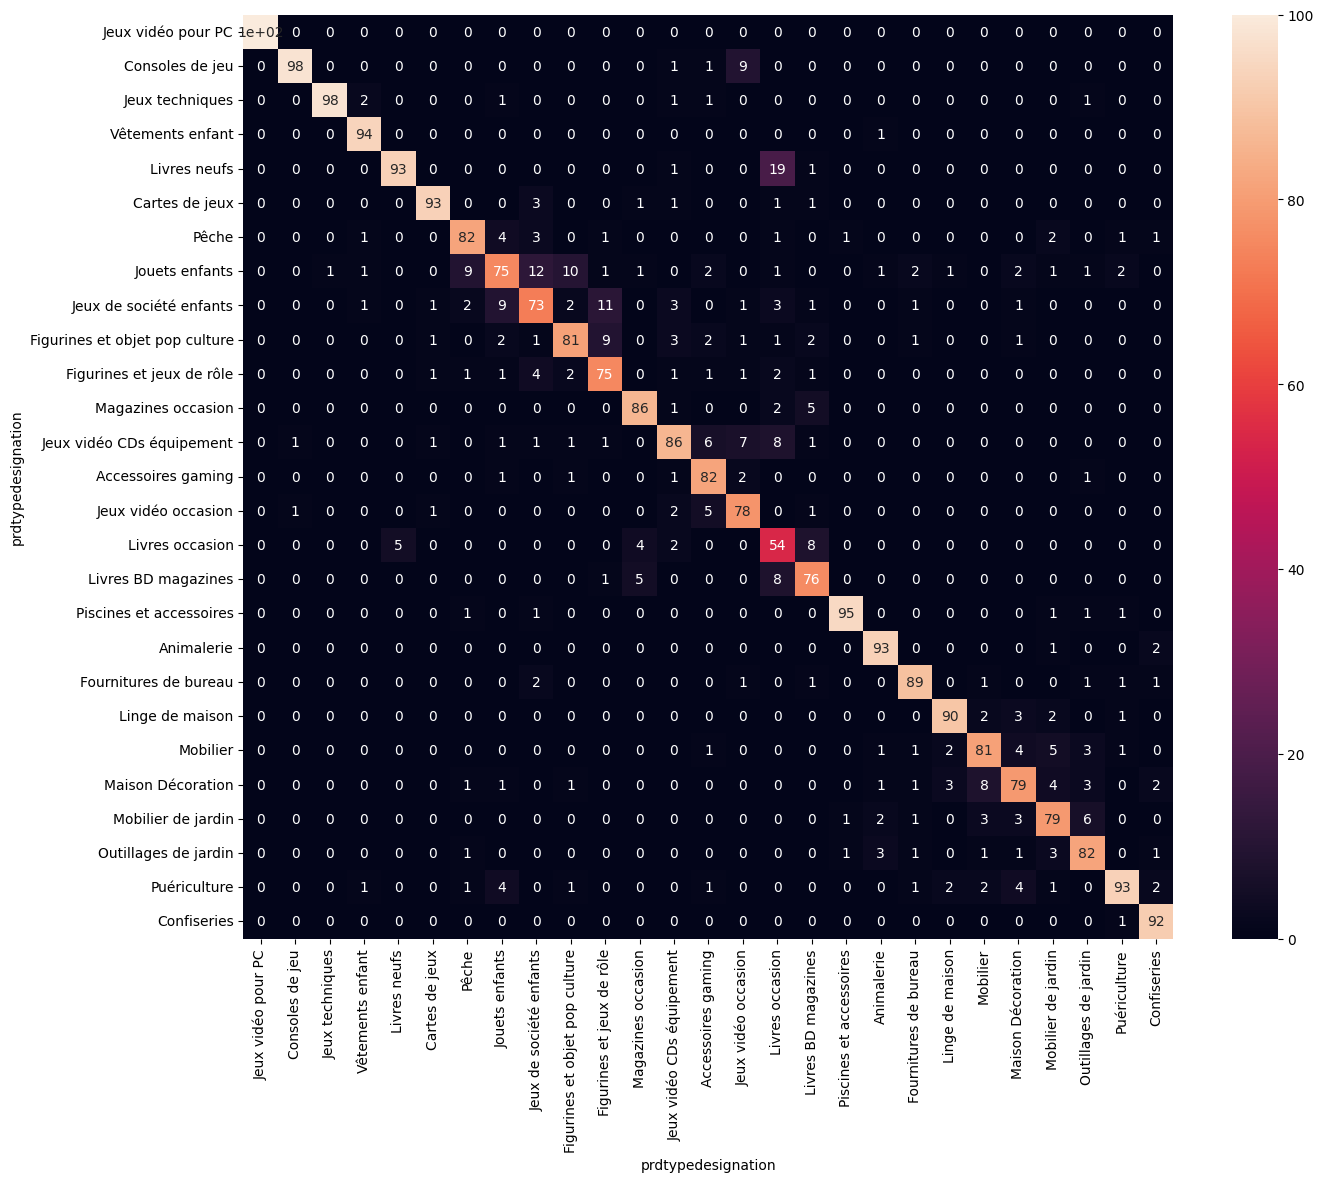

<module 'matplotlib.pyplot' from '/home/jul/anaconda3/envs/Rakuten/lib/python3.11/site-packages/matplotlib/pyplot.py'>

In [26]:
plot_classification_results(y_test, y_txt_pred, index=class_labels['prdtypedesignation'])

## ViT classifier

In [5]:
model_ViT = ImgClassifier(base_name='vit_b16', from_trained = None, img_size=(224, 224, 3), num_class=27, drop_rate=0.2, epochs=5, batch_size=32, learning_rate=5e-5)
# model_resnet50 = ImgClassifier(base_name='ResNet50', from_trained = None, img_size=(224, 224, 3), num_class=27, drop_rate=0.2, epochs=1, batch_size=32, learning_rate=5e-5)
# model_vgg16 = ImgClassifier(base_name='VGG16', from_trained = None, img_size=(224, 224, 3), num_class=27, drop_rate=0.2, epochs=1, batch_size=32, learning_rate=5e-5)
# model_efficientNet = ImgClassifier(base_name='EfficientNetB1', from_trained = 'EfficientNet_test', img_size=(224, 224, 3), num_class=27, drop_rate=0.2, epochs=1, batch_size=32, learning_rate=5e-5)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2024-03-07 14:53:15.733051: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:17:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-07 14:53:15.733468: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:73:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-07 14:53:15.850630: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:17:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-07 14:53:15.850742: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:73:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-07 14:53:15.850798: I external/local_xla/xla/stream_executor

In [7]:
model_ViT.fit(X_train, y_train)
# model_resnet50.fit(X_train[:10000], y_train[:10000])
# model_vgg16.fit(X_train[:10000], y_train[:10000])
# model_efficientNet.fit(X_train[:10000], y_train[:10000])

Found 67932 validated image filenames.
Epoch 1/5
INFO:tensorflow:Collective all_reduce tensors: 202 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Collective all_reduce tensors: 202 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CP

2024-03-07 14:54:51.339911: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-03-07 14:54:51.357988: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-03-07 14:54:54.433433: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-07 14:54:55.168684: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-07 14:54:58.958723: I external/local_xla/xla/service/service.cc:168] XLA service 0x7effa8bd1a20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-07 14:54:58.958819: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A5000, Compute Capability 8.6
2024-03-07 14:54:58.958838: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA RTX A5000, Compu

2123/2123 [==============================] - ETA: 0s - loss: 1.6784 - accuracy: 0.5179INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
2123/2123 [==============================] - 1092s 478ms/step - loss: 1.6784 - accuracy: 0.5179
Epoch 2/5
1547/2123 [====================>.........] - ETA: 4:22 - loss: 1.1998 - accuracy: 0.6431

In [18]:
y_img_pred = model_efficientNet.predict(X_test[:100])

f1_score(y_test[:100], y_img_pred, average='weighted')

Found 100 validated image filenames.
4/4 [==============================] - 5s 53ms/step


0.2976160079686396

In [10]:
# model_ViT.save(name='ViT_test')
model_efficientNet.save(name='EfficientNet_test')

In [ ]:
plot_training_history(model_ViT.history)

              precision    recall  f1-score   support

           0       0.41      0.66      0.51       623
           1       0.60      0.69      0.64       534
           2       0.77      0.95      0.85       791
           3       0.49      0.20      0.28       153
           4       0.50      0.32      0.39       974
           5       0.34      0.33      0.33       414
           6       0.65      0.72      0.69      1009
           7       0.87      0.52      0.65       161
           8       0.54      0.32      0.40       498
           9       0.57      0.40      0.47       648
          10       0.60      0.61      0.60      1015
          11       0.78      0.83      0.80       861
          12       0.69      0.70      0.69       161
          13       0.42      0.64      0.51       999
          14       0.88      0.21      0.34       165
          15       0.78      0.81      0.79       952
          16       0.72      0.64      0.68       955
          17       0.71    

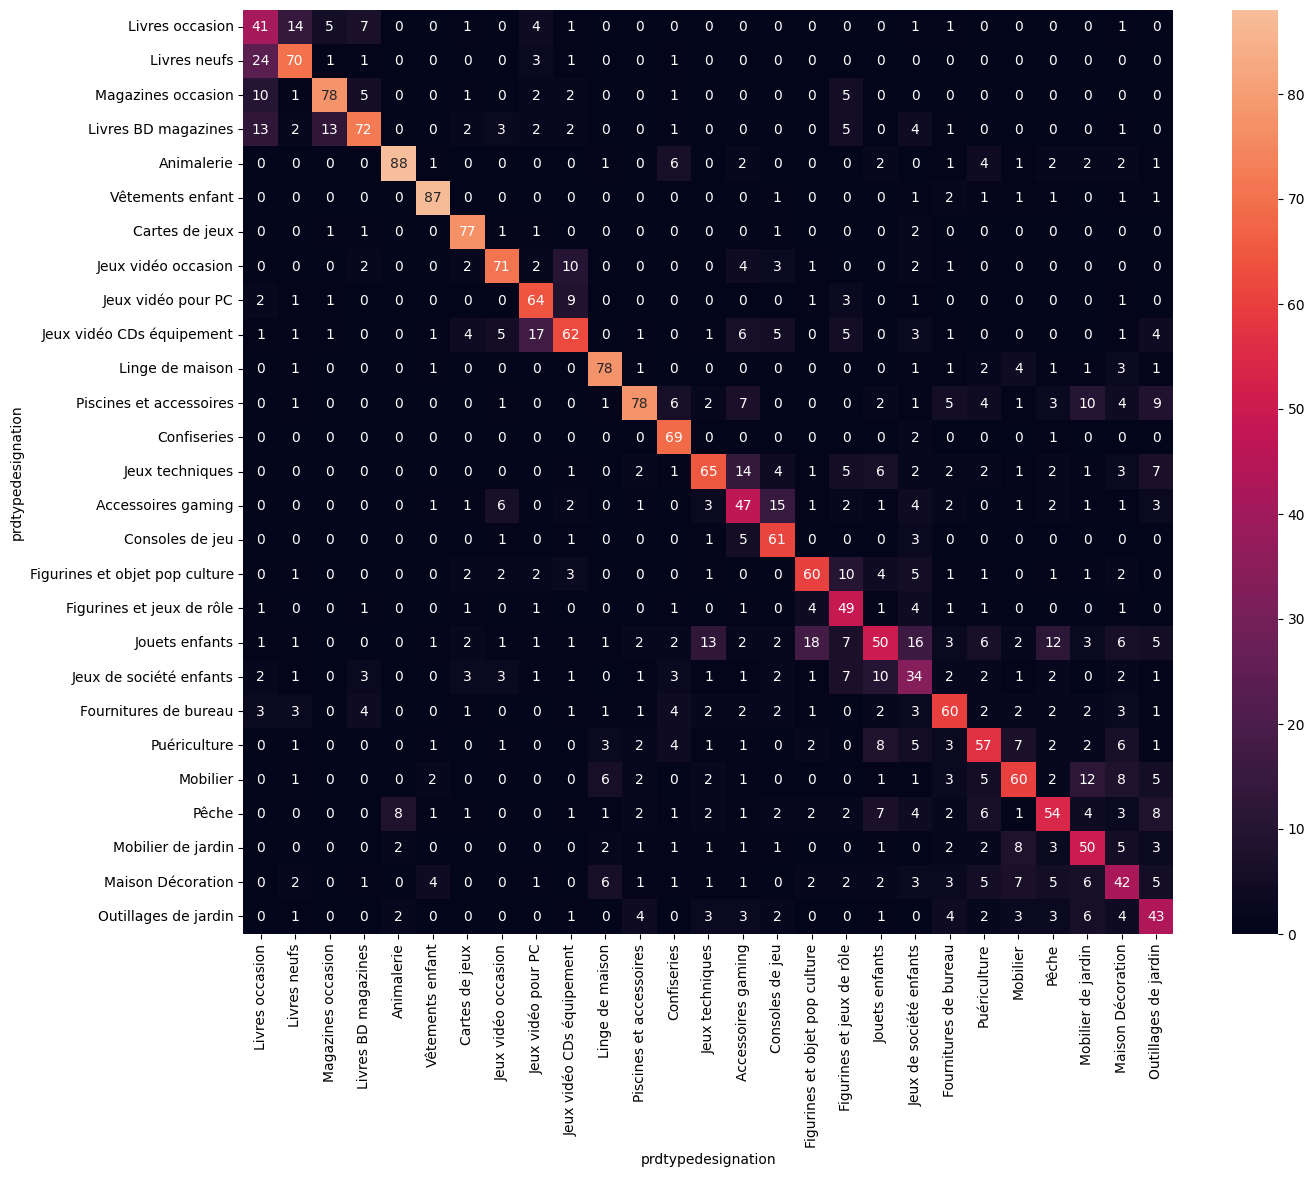

<module 'matplotlib.pyplot' from '/home/jul/anaconda3/envs/Rakuten/lib/python3.11/site-packages/matplotlib/pyplot.py'>

In [25]:
plot_classification_results(y_test, y_img_pred, index=class_labels['prdtypedesignation'])

## Voting classifier with Bert and ViT

In [14]:
from sklearn.ensemble import VotingClassifier

model_txt = TFbertClassifier(base_name='camembert-base', from_trained = 'Bert_test', max_length=256, num_class=27, drop_rate=0.2, epochs=0)
model_img = ImgClassifier(base_name='b16', from_trained = 'ViT_test', img_size=(224, 224, 3), num_class=27, drop_rate=0.2, batch_size=32, learning_rate=5e-5, epochs=0)

voting_clf = VotingClassifier(estimators = [('txt_clf', model_txt), ('img_clf', model_img)], voting='soft', weights=[0.6, 0.4])
voting_clf.fit(X_train, y_train)

All model checkpoint layers were used when initializing TFCamembertModel.

All the layers of TFCamembertModel were initialized from the model checkpoint at /mnt/c/Users/Julien Fournier/Documents/GitHub/RakutenTeam/src/text/../../models/base_models/camembert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFCamembertModel for predictions without further training.


loading weights from  Bert_test


/home/jul/anaconda3/envs/Rakuten/lib/python3.11/site-packages/vit_keras/utils.py:81: UserWarning:

Resizing position embeddings from 24, 24 to 14, 14



loading weights from  ViT_test


All model checkpoint layers were used when initializing TFCamembertModel.

All the layers of TFCamembertModel were initialized from the model checkpoint at /mnt/c/Users/Julien Fournier/Documents/GitHub/RakutenTeam/src/text/../../models/base_models/camembert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFCamembertModel for predictions without further training.


loading weights from  Bert_test


/home/jul/anaconda3/envs/Rakuten/lib/python3.11/site-packages/vit_keras/utils.py:81: UserWarning:

Resizing position embeddings from 24, 24 to 14, 14



loading weights from  ViT_test


VotingClassifier(estimators=[('txt_clf',
                              TFbertClassifier(epochs=0,
                                               from_trained='Bert_test')),
                             ('img_clf',
                              ViTClassifier(augmentation_params={'cval': 255,
                                                                 'fill_mode': 'constant',
                                                                 'height_shift_range': 0.1,
                                                                 'horizontal_flip': True,
                                                                 'rotation_range': 20,
                                                                 'width_shift_range': 0.1},
                                            epochs=0,
                                            from_trained='ViT_test'))],
                 voting='soft', weights=[0.6, 0.4])

In [11]:
voting_pred = voting_clf.predict(X_test)
f1_score(y_test, voting_pred, average='weighted')

2024-03-06 02:10:01.856308: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


531/531 [==============================] - 154s 275ms/step
Found 16984 validated image filenames.


2024-03-06 02:12:36.438034: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-03-06 02:12:39.342531: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


531/531 [==============================] - 140s 251ms/step


0.8585865972586947

## Stacking classifier with Bert and ViT

In [12]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

model_txt = TFbertClassifier(base_name='camembert-base', from_trained = 'Bert_test', max_length=256, num_class=27, drop_rate=0.2, epochs=0)
model_img = ImgClassifier(base_name='b16', from_trained = 'ViT_test', img_size=(224, 224, 3), num_class=27, drop_rate=0.2, batch_size=32, learning_rate=5e-5, epochs=0)
final_clf = LogisticRegression(C=1.0, penalty='l2')

stacking_clf = StackingClassifier(estimators = [('txt_clf', model_txt), ('img_clf', model_img)], final_estimator=final_clf, cv='prefit', stack_method='predict_proba')
stacking_clf.fit(X_test, y_test)

loading from Local


All model checkpoint layers were used when initializing TFCamembertModel.

All the layers of TFCamembertModel were initialized from the model checkpoint at /mnt/c/Users/Julien Fournier/Documents/GitHub/RakutenTeam/src/text/../../models/base_models/camembert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFCamembertModel for predictions without further training.


loading weights from  Bert_test


/home/jul/anaconda3/envs/Rakuten/lib/python3.11/site-packages/vit_keras/utils.py:81: UserWarning:

Resizing position embeddings from 24, 24 to 14, 14



loading weights from  ViT_test
531/531 [==============================] - 148s 274ms/step
Found 16984 validated image filenames.


2024-03-06 08:50:07.369828: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-03-06 08:50:10.671323: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


531/531 [==============================] - 137s 244ms/step


StackingClassifier(cv='prefit',
                   estimators=[('txt_clf',
                                TFbertClassifier(epochs=0,
                                                 from_trained='Bert_test')),
                               ('img_clf',
                                ViTClassifier(augmentation_params={'cval': 255,
                                                                   'fill_mode': 'constant',
                                                                   'height_shift_range': 0.1,
                                                                   'horizontal_flip': True,
                                                                   'rotation_range': 20,
                                                                   'width_shift_range': 0.1},
                                              epochs=0,
                                              from_trained='ViT_test'))],
                   final_estimator=LogisticRegression(),
                   stack_method='predict_proba')

In [13]:
stacking_pred = stacking_clf.predict(X_test)
f1_score(y_test, stacking_pred, average='weighted')

531/531 [==============================] - 146s 274ms/step
Found 16984 validated image filenames.
531/531 [==============================] - 130s 245ms/step


0.868771593772429

## MultiModal transformer

In [5]:
model_multi = TFmultiClassifier(txt_base_name='camembert-base', img_base_name='b16', from_trained = None, 
                                 max_length=256, img_size=(224, 224, 3), augmentation_params=None,
                                 num_class=27, drop_rate=0.2,
                                 epochs=3, batch_size=32, learning_rate=2e-5, callbacks=None)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2024-03-07 11:04:16.036414: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:17:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-07 11:04:16.036796: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:73:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-07 11:04:16.088917: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:17:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-07 11:04:16.089002: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:73:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-07 11:04:16.089048: I external/local_xla/xla/stream_executor

In [6]:
model_multi.epochs = 3
model_multi.fit(X_train, y_train)

Found 32 validated image filenames.
Epoch 1/3
INFO:tensorflow:Collective all_reduce tensors: 398 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Collective all_reduce IndexedSlices: 3 all_reduces, num_devices =2, group_size = 2, implementation = CommunicationImplementation.NCCL
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Collective all_reduce tensors: 398 all_reduces, num_devices = 2, g

2024-03-07 11:07:13.459336: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-03-07 11:07:13.481737: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-03-07 11:07:13.878915: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-07 11:07:17.167105: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-07 11:07:19.817074: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f9b24252a10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-07 11:07:19.817199: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A5000, Compute Capability 8.6
2024-03-07 11:07:19.817222: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA RTX A5000, Compu

2123/2123 [==============================] - ETA: 0s - loss: 3.0943 - accuracy: 0.2970INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
2123/2123 [==============================] - 2055s 898ms/step - loss: 3.0943 - accuracy: 0.2970
Epoch 2/3
Found 32 validated image filenames.
Found 32 validated image filenames.
Found 32 validated image filenames.
   1/2123 [..............................] - ETA: 44:23 - loss: 3.0638 - accuracy: 0.2500Found 32 validated image filenames.
Found 32 validated image filenames.
   2/2123 [..............................] - ETA: 31:13 - loss: 3.0734 - accuracy: 0.2500Found 32 validated image filenames.
Found 32 validated image filenames.
   3/2123 [..............................] - ETA: 30:56 - loss: 3.0721 - accuracy: 0.2708Found 32 

KeyboardInterrupt: 

In [7]:
y_multi_pred = model_multi.predict(X_test)

f1_score(y_test, y_multi_pred, average='weighted')

Found 32 validated image filenames.
Found 32 validated image filenames.
Found 32 validated image filenames.
Found 32 validated image filenames.
Found 32 validated image filenames.
Found 32 validated image filenames.
Found 32 validated image filenames.
  1/531 [..............................] - ETA: 1:45:08Found 32 validated image filenames.
Found 32 validated image filenames.
531/531 [==============================] - 165s 288ms/step


0.8839811644704751